### HR Analytics XGBoost Share Model

#### Imports

In [71]:
import keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost as xgb

In [48]:
%matplotlib inline

#### SHAP Initialization

In [22]:
use_shap = True

In [23]:
# load JS visualization code to notebook
if use_shap:
    shap.initjs()

#### Train and Test Files

In [24]:
pwd

'C:\\Users\\t0272m1\\Projects\\HR Analytics'

In [96]:
path = 'E:/HR-Analytics/data/'

In [109]:
file_name = 'abs_jnap_model_seq_20190804_tbl.csv'
df = pd.read_csv('/'.join([path, file_name]))

In [110]:
df.shape

(25580, 48)

In [111]:
use_categoricals = False
if use_categoricals:
    df['crew'], _ = pd.factorize(df['crew'])
    df['production_line'], _ = pd.factorize(df['production_line'])
    df.drop(columns=['workdate'], inplace=True)

In [112]:
df.sample(20)

,workdate,crew,production_line,group_total_cid,lost_hours,actual_hours,paa_hours,absences_unplanned,absences_late,absences_noshow,...,kp_residual_20,year,quarter,month,week,day,day_of_week,day_of_year,nth_kday,next_day_delta
1517,2017-02-24,B,Quality 1,41.0,30.0,417.4,8.0,4,0.0,3.0,...,-0.000000,2017,1,2,8,24,4,55,4,1.0
23097,2019-05-01,B,Trim 2,65.0,31.7,648.6,0.0,4,2.0,3.0,...,0.857143,2019,2,5,18,1,2,121,1,1.0
7229,2017-09-15,C,,8.0,0.0,78.8,10.0,0,0.0,0.0,...,4.000000,2017,3,9,37,15,4,258,3,1.0
9428,2017-12-05,C,Paint Shop,116.0,92.6,1162.4,0.0,18,2.0,9.0,...,2.000000,2017,4,12,49,5,1,339,1,3.0
3979,2017-05-22,C,Final 2,43.0,80.9,425.1,30.0,7,1.0,8.0,...,0.000000,2017,2,5,21,22,0,142,4,1.0
13444,2018-05-03,A,Body Shop,99.0,70.0,976.6,3.0,6,0.0,7.0,...,-0.666667,2018,2,5,18,3,3,123,1,4.0
9611,2017-12-12,A,Engine Line,58.0,61.9,570.8,10.0,8,2.0,6.0,...,1000.000000,2017,4,12,50,12,1,346,2,1.0
22577,2019-04-11,B,Engine Line,61.0,50.9,607.0,0.0,5,1.0,5.0,...,6.000000,2019,2,4,15,11,3,101,2,1.0
6342,2017-08-15,A,Sunroof Deck,37.0,30.0,359.5,10.0,1,0.0,3.0,...,-2.000000,2017,3,8,33,15,1,227,3,1.0
18502,2018-11-02,C,Paint Shop,113.0,61.0,1126.1,20.0,14,3.0,6.0,...,-6.000000,2018,4,11,44,2,4,306,1,1.0


In [113]:
for f in df.columns:
    print(f, df[f].dtype)

workdate object
crew object
production_line object
group_total_cid float64
lost_hours float64
actual_hours float64
paa_hours float64
absences_unplanned int64
absences_late float64
absences_noshow float64
absences_any float64
mean_absence_pct float64
mean_experience float64
absences_planned float64
home_canvasses float64
absences_fmla float64
peia_count float64
tpt_count float64
streak_1 float64
streak_2 float64
streak_3 float64
streak_4_plus float64
cluster float64
group_total float64
tpt_unplanned float64
tpt_extra float64
absences_unplanned_rolling_sum_5 float64
absences_unplanned_rolling_median_5 float64
absences_unplanned_rolling_sum_12 float64
absences_unplanned_rolling_median_12 float64
absences_unplanned_rolling_sum_20 float64
absences_unplanned_rolling_median_20 float64
actual_hours_rolling_mean_20 float64
actual_hours_rolling_median_20 float64
lost_hours_rolling_mean_20 float64
lost_hours_rolling_median_20 float64
kp_residual_5 float64
kp_residual_12 float64
kp_residual_20 flo

In [228]:
df = df[df['crew'] != ' ']
df = df[df['production_line'] != ' ']

In [233]:
df.crew.value_counts(dropna=False)

B    8119
A    8012
C    7936
Name: crew, dtype: int64

In [234]:
df.production_line.value_counts(dropna=False)

Body Shop        1514
Paint Shop       1514
Material         1512
Quality 1        1512
Rolls            1509
Chassis 3        1506
Final 1          1505
Chassis 1 & 2    1503
Trim 1           1502
Sunroof Deck     1501
Door Line        1500
Final 2          1500
Chassis 4        1499
Quality 2        1497
Engine Line      1497
Trim 2           1496
Name: production_line, dtype: int64

In [223]:
pcts_col = ['crew', 'production_line']
pcts_col

['crew', 'production_line']

In [211]:
au_target = 'absences_unplanned_rolling_sum_12'
au_target

'absences_unplanned_rolling_sum_12'

In [249]:
df_au = df[df['workdate'] >= '2019-05-01'].groupby(pcts_col).agg({au_target : 'mean'}).reset_index()

In [250]:
df_au.columns

Index(['crew', 'production_line', 'absences_unplanned_rolling_sum_12'], dtype='object')

In [251]:
df_au

,crew,production_line,absences_unplanned_rolling_sum_12
0,A,Body Shop,59.770833
1,A,Chassis 1 & 2,95.458333
2,A,Chassis 3,86.229167
3,A,Chassis 4,83.291667
4,A,Door Line,52.416667
5,A,Engine Line,77.375000
6,A,Final 1,112.687500
7,A,Final 2,51.729167
8,A,Material,84.125000
9,A,Paint Shop,99.208333


In [252]:
df_pcts = df_au.groupby('crew')[au_target].apply(lambda x: 100 * x / float(x.sum()))

In [253]:
df_au['pct'] = df_pcts

In [254]:
df_au.sample(20)

,crew,production_line,absences_unplanned_rolling_sum_12,pct
29,B,Sunroof Deck,43.764706,3.127540
12,A,Rolls,20.625000,1.700943
30,B,Trim 1,150.254902,10.737606
6,A,Final 1,112.687500,9.293335
9,A,Paint Shop,99.208333,8.181709
28,B,Rolls,24.843137,1.775355
25,B,Paint Shop,127.392157,9.103775
37,C,Engine Line,143.734694,7.634937
44,C,Rolls,46.448980,2.467289
16,B,Body Shop,102.215686,7.304599


In [255]:
df_au[df_au['crew'] == 'A']

,crew,production_line,absences_unplanned_rolling_sum_12,pct
0,A,Body Shop,59.770833,4.929299
1,A,Chassis 1 & 2,95.458333,7.872446
2,A,Chassis 3,86.229167,7.111317
3,A,Chassis 4,83.291667,6.869062
4,A,Door Line,52.416667,4.322801
5,A,Engine Line,77.375000,6.381114
6,A,Final 1,112.687500,9.293335
7,A,Final 2,51.729167,4.266103
8,A,Material,84.125000,6.937787
9,A,Paint Shop,99.208333,8.181709


In [256]:
df_au[df_au['crew'] == 'B']

,crew,production_line,absences_unplanned_rolling_sum_12,pct
16,B,Body Shop,102.215686,7.304599
17,B,Chassis 1 & 2,117.176471,8.373735
18,B,Chassis 3,111.058824,7.936552
19,B,Chassis 4,55.843137,3.990696
20,B,Door Line,91.862745,6.564751
21,B,Engine Line,111.764706,7.986997
22,B,Final 1,92.980392,6.644621
23,B,Final 2,53.078431,3.793123
24,B,Material,154.843137,11.065493
25,B,Paint Shop,127.392157,9.103775


In [257]:
df_au[df_au['crew'] == 'C']

,crew,production_line,absences_unplanned_rolling_sum_12,pct
32,C,Body Shop,137.122449,7.283706
33,C,Chassis 1 & 2,144.387755,7.669626
34,C,Chassis 3,121.142857,6.434898
35,C,Chassis 4,83.938776,4.458682
36,C,Door Line,108.530612,5.764957
37,C,Engine Line,143.734694,7.634937
38,C,Final 1,121.877551,6.473923
39,C,Final 2,76.877551,4.083602
40,C,Material,175.612245,9.328217
41,C,Paint Shop,178.836735,9.499496


#### Share Model

In [289]:
sel_cols = ['workdate',
            'crew',
            'absences_unplanned',
            'actual_hours',
            'lost_hours',
            'absences_unplanned_rolling_median_12',
            'absences_unplanned_rolling_median_20',
            'year',
            'quarter',
            'month',
            'week',
            'day',
            'day_of_week',
            'day_of_year'
            ]
sel_cols

['workdate',
 'crew',
 'absences_unplanned',
 'actual_hours',
 'lost_hours',
 'absences_unplanned_rolling_median_12',
 'absences_unplanned_rolling_median_20',
 'year',
 'quarter',
 'month',
 'week',
 'day',
 'day_of_week',
 'day_of_year']

In [290]:
df_agg = df[sel_cols]
df_agg.sample(10)

,workdate,crew,absences_unplanned,actual_hours,lost_hours,absences_unplanned_rolling_median_12,absences_unplanned_rolling_median_20,year,quarter,month,week,day,day_of_week,day_of_year
20125,2019-01-16,B,6,904.1,30.1,3.5,4.0,2019,1,1,3,16,2,16
6293,2017-08-12,C,4,704.7,20.0,5.5,6.0,2017,3,8,32,12,5,224
23607,2019-05-18,C,11,705.6,90.0,9.5,9.0,2019,2,5,20,18,5,138
16769,2018-09-04,C,2,477.0,60.0,4.5,4.0,2018,3,9,36,4,1,247
2136,2017-03-17,C,7,853.3,60.5,10.0,9.5,2017,1,3,11,17,4,76
8590,2017-11-02,B,4,1023.6,11.7,5.5,5.5,2017,4,11,44,2,3,306
16607,2018-08-22,A,5,828.8,51.9,6.5,6.0,2018,3,8,34,22,2,234
10751,2018-01-27,C,2,572.2,20.0,2.5,2.0,2018,1,1,4,27,5,27
16963,2018-09-11,C,13,867.7,100.8,9.5,9.0,2018,3,9,37,11,1,254
4189,2017-05-30,C,6,372.8,10.2,4.0,4.0,2017,2,5,22,30,1,150


In [116]:
group_cols = ['workdate', 'crew']

In [121]:
def weighted_mean(x):
    try:
        return np.average(x, weights=df_agg.loc[x.index, 'absences_unplanned'])
    except:
        return 0

In [287]:
agg_dict = {'absences_unplanned'                   : {'absences_unplanned' : 'sum'},
            'actual_hours'                         : {'actual_hours_wmean' : weighted_mean},
            'lost_hours'                           : {'lost_hours_wmean' : weighted_mean},
            'absences_unplanned_rolling_median_12' : {'au_rmedian_12' : weighted_mean},
            'absences_unplanned_rolling_median_20' : {'au_rmedian_20' : weighted_mean},
            'year'                                 : {'year' : 'first'},
            'quarter'                              : {'quarter' : 'first'},
            'month'                                : {'month' : 'first'},
            'week'                                 : {'week' : 'first'},
            'day'                                  : {'day' : 'first'},
            'day_of_week'                          : {'day_of_week' : 'first'},
            'day_of_year'                          : {'day_of_year' : 'first'}
           }
agg_dict

{'absences_unplanned': {'absences_unplanned': 'sum'},
 'actual_hours': {'actual_hours_wmean': <function __main__.weighted_mean(x)>},
 'lost_hours': {'lost_hours_wmean': <function __main__.weighted_mean(x)>},
 'absences_unplanned_rolling_median_12': {'au_rmedian_12': <function __main__.weighted_mean(x)>},
 'absences_unplanned_rolling_median_20': {'au_rmedian_20': <function __main__.weighted_mean(x)>},
 'year': {'year': 'first'},
 'quarter': {'quarter': 'first'},
 'month': {'month': 'first'},
 'week': {'week': 'first'},
 'day': {'day': 'first'},
 'day_of_week': {'day_of_week': 'first'},
 'day_of_year': {'day_of_year': 'first'}}

In [332]:
# aggregate cluster features
dfm = df_agg.groupby(group_cols).agg(agg_dict).reset_index()

In [333]:
dfm.columns = ['workdate',
               'crew',
               'absences_unplanned',
               'actual_hours_wmean',
               'lost_hours_wmean',
               'au_rmedian_12',
               'au_rmedian_20',
               'year',
               'quarter',
               'month',
               'week',
               'day',
               'day_of_week',
               'day_of_year']

In [334]:
dfm.tail(10)

,workdate,crew,absences_unplanned,actual_hours_wmean,lost_hours_wmean,au_rmedian_12,au_rmedian_20,year,quarter,month,week,day,day_of_week,day_of_year
1504,2019-07-23,A,85,767.090588,77.601176,6.676471,6.605882,2019,3,7,30,23,1,204
1505,2019-07-23,C,132,739.952273,85.329545,10.924242,10.727273,2019,3,7,30,23,1,204
1506,2019-07-24,A,76,752.969737,48.497368,6.427632,6.348684,2019,3,7,30,24,2,205
1507,2019-07-24,B,117,718.358974,131.073504,8.670940,8.854701,2019,3,7,30,24,2,205
1508,2019-07-25,A,116,796.402586,48.665517,6.452586,6.646552,2019,3,7,30,25,3,206
1509,2019-07-25,B,81,754.717284,71.241975,8.234568,8.345679,2019,3,7,30,25,3,206
1510,2019-07-26,B,89,761.276404,42.334831,7.713483,7.865169,2019,3,7,30,26,4,207
1511,2019-07-26,C,138,729.836957,70.954348,10.568841,10.500000,2019,3,7,30,26,4,207
1512,2019-07-27,B,111,764.064865,46.475676,7.927928,7.909910,2019,3,7,30,27,5,208
1513,2019-07-27,C,150,725.958667,76.726667,10.533333,10.923333,2019,3,7,30,27,5,208


In [153]:
dfm['absences_unplanned'].value_counts()

74     25
109    24
70     24
87     23
97     23
83     23
80     23
112    23
99     23
98     23
65     22
77     22
90     21
113    21
75     21
105    20
81     20
84     20
121    20
115    20
89     19
101    19
91     19
66     19
94     18
85     18
107    18
88     18
78     18
119    18
       ..
180     2
181     2
183     2
187     2
161     2
189     2
167     2
36      1
50      1
43      1
22      1
21      1
162     1
157     1
2       1
268     1
192     1
171     1
174     1
196     1
241     1
185     1
186     1
232     1
227     1
215     1
201     1
200     1
198     1
290     1
Name: absences_unplanned, Length: 164, dtype: int64

#### Model

In [335]:
target = 'absences_unplanned'
y = dfm[target]
X = dfm.drop(columns=[target])
print(X.shape, y.shape)

(1514, 13) (1514,)


In [336]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [337]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1014, 13), (500, 13), (1014,), (500,))

In [338]:
y_test.shape[0]

500

In [339]:
X_test.tail()

,workdate,crew,actual_hours_wmean,lost_hours_wmean,au_rmedian_12,au_rmedian_20,year,quarter,month,week,day,day_of_week,day_of_year
710,2018-03-10,B,784.547059,48.760294,6.073529,6.375000,2018,1,3,10,10,5,69
798,2018-05-03,A,778.362921,67.449438,5.848315,5.640449,2018,2,5,18,3,3,123
158,2017-04-05,A,718.087379,62.638835,7.169903,7.461165,2017,2,4,14,5,2,95
1027,2018-09-24,C,803.974016,42.231496,8.452756,8.370079,2018,3,9,39,24,0,267
1344,2019-04-16,A,737.480000,52.220000,6.100000,6.078571,2019,2,4,16,16,1,106


In [340]:
X_test['day'][-5:]

710     10
798      3
158      5
1027    24
1344    16
Name: day, dtype: int64

In [341]:
drop_cols = ['workdate', 'crew']
X_train_final = X_train.drop(columns=drop_cols)
X_test_final = X_test.drop(columns=drop_cols)

#### XGBoost Training

In [136]:
dtrain = xgb.DMatrix(X_train_final, y_train)
dtest = xgb.DMatrix(X_test_final, y_test)

In [154]:
params = {
    "objective": "reg:linear",
    "booster" : "gbtree",
    "eval_metric": "mae",
    "eta": 0.1,
    "tree_method": 'exact',
    "max_depth": 4,
    "subsample": 1,
    "colsample_bytree": 1,
    "silent": 1,
    "min_chil_weight": 1,
    "seed": 42
}

num_rounds = 1000
early_stopping_rounds = 10

In [155]:
# train XGBoost model
eval_set = [(dtrain, 'train'), (dtest, 'eval')]
gbm = xgb.train(params, dtrain, num_rounds, evals=eval_set, early_stopping_rounds=early_stopping_rounds)

[0]	train-mae:90.1269	eval-mae:90.206
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:81.2106	eval-mae:81.3186
[2]	train-mae:73.2037	eval-mae:73.3093
[3]	train-mae:66.0021	eval-mae:66.078
[4]	train-mae:59.5143	eval-mae:59.688
[5]	train-mae:53.6732	eval-mae:53.8472
[6]	train-mae:48.4172	eval-mae:48.6806
[7]	train-mae:43.6919	eval-mae:43.9833
[8]	train-mae:39.4755	eval-mae:39.7809
[9]	train-mae:35.7324	eval-mae:36.0057
[10]	train-mae:32.4196	eval-mae:32.6259
[11]	train-mae:29.5226	eval-mae:29.727
[12]	train-mae:26.9725	eval-mae:27.2283
[13]	train-mae:24.8285	eval-mae:25.1697
[14]	train-mae:23.0069	eval-mae:23.4563
[15]	train-mae:21.4861	eval-mae:22.0334
[16]	train-mae:20.2134	eval-mae:20.7838
[17]	train-mae:19.1443	eval-mae:19.7518
[18]	train-mae:18.2363	eval-mae:18.8937
[19]	train-mae:17.4848	eval-mae:18.2352
[20]	train-mae:16.8279	eval-mae:17.6413
[21]	train-mae:16.2988	eval-mae:1

In [158]:
gbm

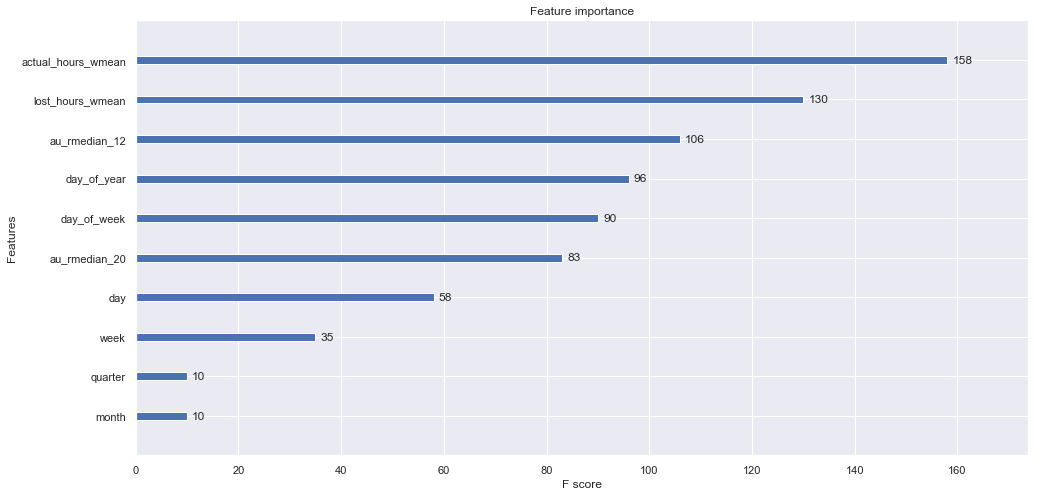

In [157]:
xgb.plot_importance(gbm, max_num_features=20)

#### XGBoost Testing

In [159]:
ypred = gbm.predict(xgb.DMatrix(X_test))

In [160]:
ypred.shape

(500,)

In [161]:
ypred.max()

170.24097

In [162]:
np.count_nonzero((ypred > 20) == True)

496

In [163]:
y_test.shape

(500,)

In [164]:
y_test.max()

290

In [165]:
np.count_nonzero((y_test > 20) == True)

492

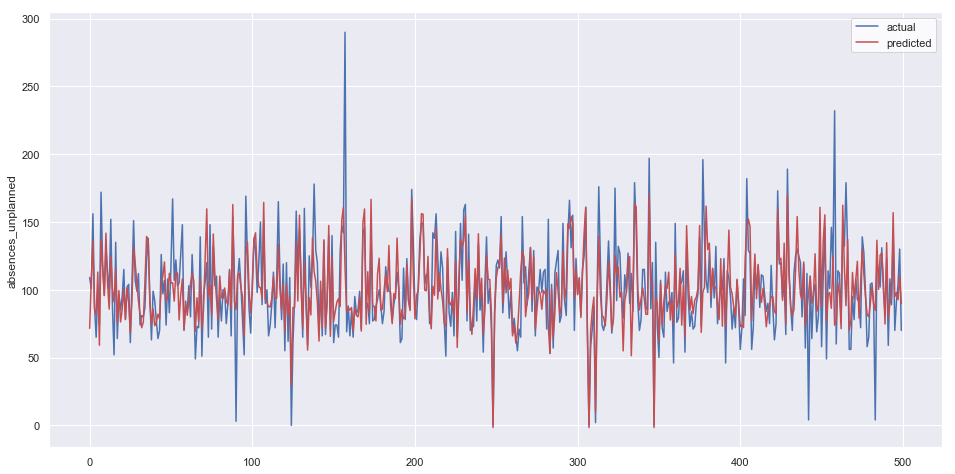

In [166]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(x=range(y_test.shape[0]), y=y_test, color='b', ax=ax)
sns.lineplot(x=range(ypred.shape[0]), y=ypred, color='r', ax=ax)
ax.legend(['actual', 'predicted'], facecolor='w')
plt.show()

In [426]:
diffs = (y_test.values - ypred).tolist()

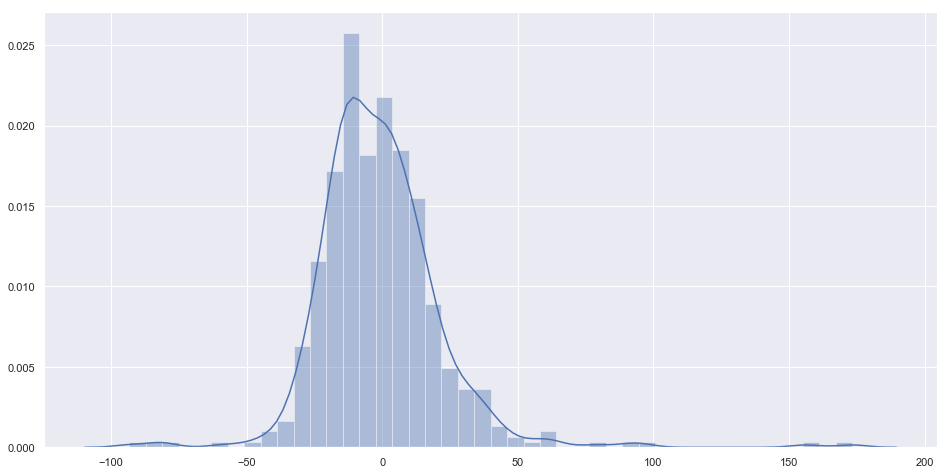

In [427]:
sns.distplot(diffs)

In [428]:
df_q = pd.DataFrame({'actual':y_test.values, 'predicted':ypred, 'diff':diffs}).reset_index(drop=True)
df_q.tail()

,actual,predicted,diff
495,68,94.884956,-26.884956
496,89,97.919640,-8.919640
497,103,92.695084,10.304916
498,127,110.502434,16.497566
499,70,89.629646,-19.629646


In [429]:
df_m = X_test.reset_index(drop=True)
df_m.tail()

,workdate,crew,actual_hours_wmean,lost_hours_wmean,au_rmedian_12,au_rmedian_20,year,quarter,month,week,day,day_of_week,day_of_year
495,2018-03-10,B,784.547059,48.760294,6.073529,6.375000,2018,1,3,10,10,5,69
496,2018-05-03,A,778.362921,67.449438,5.848315,5.640449,2018,2,5,18,3,3,123
497,2017-04-05,A,718.087379,62.638835,7.169903,7.461165,2017,2,4,14,5,2,95
498,2018-09-24,C,803.974016,42.231496,8.452756,8.370079,2018,3,9,39,24,0,267
499,2019-04-16,A,737.480000,52.220000,6.100000,6.078571,2019,2,4,16,16,1,106


In [430]:
df_q['crew'] = df_m['crew']
df_q['year'] = df_m['year']
df_q['month'] = df_m['month']
df_q['day'] = df_m['day']
df_q['workdate'] = pd.to_datetime(df_m[['year', 'month', 'day']]).apply(lambda x: x.strftime('%Y-%m-%d'))

In [431]:
df_q.tail(10)

,actual,predicted,diff,crew,year,month,day,workdate
490,121,134.701416,-13.701416,A,2019,6,17,2019-06-17
491,58,79.578957,-21.578957,A,2018,3,26,2018-03-26
492,105,89.605011,15.394989,C,2017,9,19,2017-09-19
493,88,94.650223,-6.650223,B,2018,2,14,2018-02-14
494,141,156.892014,-15.892014,C,2018,6,12,2018-06-12
495,68,94.884956,-26.884956,B,2018,3,10,2018-03-10
496,89,97.919640,-8.919640,A,2018,5,3,2018-05-03
497,103,92.695084,10.304916,A,2017,4,5,2017-04-05
498,127,110.502434,16.497566,C,2018,9,24,2018-09-24
499,70,89.629646,-19.629646,A,2019,4,16,2019-04-16


In [432]:
df_q['diff'].quantile(0.6826)

5.397129255676278

In [433]:
df_q['diff'].quantile(0.8)

12.519725036621102

In [434]:
df_q['diff'].quantile(0.9544)

35.54399020385743

In [435]:
from sklearn.metrics import r2_score
r2_score(y_test, ypred)

0.5319431163027215

In [436]:
from sklearn.metrics import mean_absolute_error
error = mean_absolute_error(y_test, ypred)
print('Test MAE: %.3f' % error)

Test MAE: 15.688


#### Share Model Analysis

In [437]:
dfs = df.copy(deep=True).reset_index(drop=True)

In [438]:
dfs.sample(10)

,workdate,crew,production_line,group_total_cid,lost_hours,actual_hours,paa_hours,absences_unplanned,absences_late,absences_noshow,...,kp_residual_20,year,quarter,month,week,day,day_of_week,day_of_year,nth_kday,next_day_delta
7351,2017-10-06,C,Final 1,63.0,40.0,609.5,10.0,5,0.0,4.0,...,0.000000,2017,4,10,40,6,4,279,1,1.0
20944,2019-04-01,A,Sunroof Deck,34.0,40.0,344.4,18.0,5,0.0,4.0,...,1.000000,2019,2,4,14,1,0,91,1,1.0
22705,2019-06-07,B,Trim 1,114.0,90.9,1129.1,30.0,14,2.0,9.0,...,1.111111,2019,2,6,23,7,4,158,1,1.0
21666,2019-04-29,C,Trim 2,72.0,91.9,697.4,10.0,9,2.0,9.0,...,-0.666667,2019,2,4,18,29,0,119,5,1.0
16541,2018-10-02,C,Final 2,49.0,40.9,455.1,20.0,6,1.0,4.0,...,1.000000,2018,4,10,40,2,1,275,1,3.0
22184,2019-05-18,B,Engine Line,63.0,92.1,618.8,0.0,13,3.0,9.0,...,-0.800000,2019,2,5,20,18,5,138,3,4.0
16842,2018-10-13,B,Door Line,52.0,30.1,521.4,0.0,8,1.0,3.0,...,-2.000000,2018,4,10,41,13,5,286,2,4.0
18643,2018-12-22,C,Trim 1,111.0,81.6,1083.5,0.0,1,2.0,8.0,...,0.666667,2018,4,12,51,22,5,356,4,16.0
12474,2018-04-26,B,Door Line,58.0,50.0,563.6,0.0,6,0.0,5.0,...,1.500000,2018,2,4,17,26,3,116,4,1.0
18557,2018-12-19,B,Final 2,47.0,40.0,453.6,0.0,2,0.0,4.0,...,0.750000,2018,4,12,51,19,2,353,3,1.0


In [439]:
join_cols = ['crew', 'production_line']
dfs = pd.merge(dfs, df_au,
               left_on=join_cols,
               right_on=join_cols,
               how='left')

In [440]:
dfs.columns

Index(['workdate', 'crew', 'production_line', 'group_total_cid', 'lost_hours',
       'actual_hours', 'paa_hours', 'absences_unplanned', 'absences_late',
       'absences_noshow', 'absences_any', 'mean_absence_pct',
       'mean_experience', 'absences_planned', 'home_canvasses',
       'absences_fmla', 'peia_count', 'tpt_count', 'streak_1', 'streak_2',
       'streak_3', 'streak_4_plus', 'cluster', 'group_total', 'tpt_unplanned',
       'tpt_extra', 'absences_unplanned_rolling_sum_5',
       'absences_unplanned_rolling_median_5',
       'absences_unplanned_rolling_sum_12_x',
       'absences_unplanned_rolling_median_12',
       'absences_unplanned_rolling_sum_20',
       'absences_unplanned_rolling_median_20', 'actual_hours_rolling_mean_20',
       'actual_hours_rolling_median_20', 'lost_hours_rolling_mean_20',
       'lost_hours_rolling_median_20', 'kp_residual_5', 'kp_residual_12',
       'kp_residual_20', 'year', 'quarter', 'month', 'week', 'day',
       'day_of_week', 'day_of_year'

In [441]:
dfs.sample(10)

,workdate,crew,production_line,group_total_cid,lost_hours,actual_hours,paa_hours,absences_unplanned,absences_late,absences_noshow,...,quarter,month,week,day,day_of_week,day_of_year,nth_kday,next_day_delta,absences_unplanned_rolling_sum_12_y,pct
17495,2018-11-07,B,Chassis 1 & 2,83.0,62.6,830.5,0.0,4,6.0,6.0,...,4,11,45,7,2,311,1,1.0,117.176471,8.373735
4169,2017-06-08,A,Body Shop,98.0,70.3,949.8,40.0,8,1.0,7.0,...,2,6,23,8,3,159,2,4.0,59.770833,4.929299
20997,2019-04-03,A,Chassis 3,74.0,31.5,711.3,0.0,9,1.0,3.0,...,2,4,14,3,2,93,1,1.0,86.229167,7.111317
8518,2017-11-20,A,Engine Line,61.0,20.8,601.4,0.0,6,1.0,2.0,...,4,11,47,20,0,324,3,1.0,77.375000,6.381114
22874,2019-06-13,B,Final 2,48.0,10.6,472.6,10.0,2,1.0,1.0,...,2,6,24,13,3,164,2,1.0,53.078431,3.793123
20802,2019-03-26,C,Trim 2,71.0,48.1,688.7,10.0,8,8.0,4.0,...,1,3,13,26,1,85,4,3.0,121.061224,6.430561
17071,2018-10-22,A,Paint Shop,108.0,70.0,1158.4,40.0,12,0.0,7.0,...,4,10,43,22,0,295,4,1.0,99.208333,8.181709
5207,2017-07-17,A,Trim 1,108.0,91.0,1082.3,60.0,0,1.0,9.0,...,3,7,29,17,0,198,3,1.0,152.729167,12.595571
13751,2018-06-13,B,Chassis 1 & 2,78.0,80.0,772.3,60.0,8,0.0,8.0,...,2,6,24,13,2,164,2,1.0,117.176471,8.373735
6706,2017-09-12,C,Chassis 1 & 2,85.0,71.0,846.2,30.0,9,1.0,7.0,...,3,9,37,12,1,255,2,3.0,144.387755,7.669626


In [442]:
join_cols = ['workdate', 'crew']
df_q = pd.merge(df_q, dfs,
               left_on=join_cols,
               right_on=join_cols,
               how='left')

In [444]:
df_q.columns

Index(['actual', 'predicted', 'diff', 'crew', 'year_x', 'month_x', 'day_x',
       'workdate', 'production_line', 'group_total_cid', 'lost_hours',
       'actual_hours', 'paa_hours', 'absences_unplanned', 'absences_late',
       'absences_noshow', 'absences_any', 'mean_absence_pct',
       'mean_experience', 'absences_planned', 'home_canvasses',
       'absences_fmla', 'peia_count', 'tpt_count', 'streak_1', 'streak_2',
       'streak_3', 'streak_4_plus', 'cluster', 'group_total', 'tpt_unplanned',
       'tpt_extra', 'absences_unplanned_rolling_sum_5',
       'absences_unplanned_rolling_median_5',
       'absences_unplanned_rolling_sum_12_x',
       'absences_unplanned_rolling_median_12',
       'absences_unplanned_rolling_sum_20',
       'absences_unplanned_rolling_median_20', 'actual_hours_rolling_mean_20',
       'actual_hours_rolling_median_20', 'lost_hours_rolling_mean_20',
       'lost_hours_rolling_median_20', 'kp_residual_5', 'kp_residual_12',
       'kp_residual_20', 'year_y', 

In [445]:
df_q[['workdate', 'crew', 'production_line', 'absences_unplanned', 'predicted', 'pct']].sample(20)

,workdate,crew,production_line,absences_unplanned,predicted,pct
321,2019-07-11,A,Chassis 1 & 2,6,85.418640,7.872446
6833,2017-06-10,B,Chassis 1 & 2,8,110.278427,8.373735
6060,2018-12-10,C,Rolls,3,134.411346,2.467289
3840,2019-06-24,A,Chassis 4,9,108.442757,6.869062
888,2017-11-25,C,Material,15,77.649666,9.328217
1451,2017-08-01,C,Chassis 4,8,110.867958,4.458682
2521,2018-09-26,A,Rolls,1,83.994331,1.700943
1878,2018-09-28,C,Trim 1,8,100.897896,11.279500
3566,2017-11-11,B,Chassis 1 & 2,3,79.706955,8.373735
1553,2018-07-17,C,Paint Shop,18,135.222443,9.499496


In [484]:
import math
df_q['estimate'] = df_q['predicted'] * df_q['pct'] / 100.0
df_q['estimate'] = df_q['estimate'].apply(math.ceil)

In [485]:
show_cols = ['workdate', 'crew', 'production_line', 'absences_unplanned', 'estimate']
df_q[df_q['workdate'] >= '2019-07-01'][show_cols].tail(20)

,workdate,crew,production_line,absences_unplanned,estimate
6140,2019-07-17,A,Rolls,0,2
6141,2019-07-17,A,Sunroof Deck,5,4
6142,2019-07-17,A,Trim 1,9,12
6143,2019-07-17,A,Trim 2,7,8
7132,2019-07-09,C,Body Shop,7,12
7133,2019-07-09,C,Chassis 1 & 2,9,13
7134,2019-07-09,C,Chassis 3,12,11
7135,2019-07-09,C,Chassis 4,3,8
7136,2019-07-09,C,Door Line,6,10
7137,2019-07-09,C,Engine Line,8,13


In [492]:
df_test = df_q[(df_q['workdate'] >= '2019-04-01') & (df_q['crew'] == 'C') & (df_q['production_line'] == 'Trim 1')]

In [493]:
df_test['workdate'].max()

'2019-07-23'

In [494]:
error = mean_absolute_error(df_test['absences_unplanned'], df_test['estimate'])
print('Test MAE: %.3f' % error)

Test MAE: 4.286


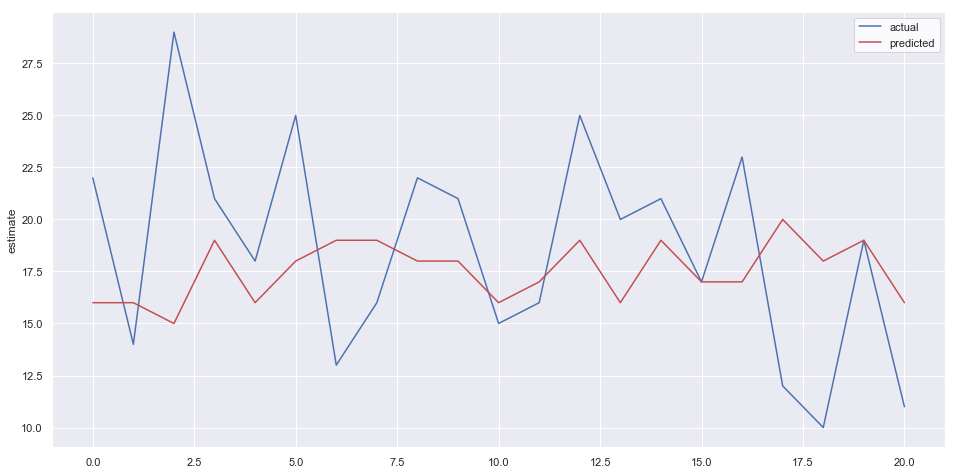

In [495]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(x=range(df_test.shape[0]), y=df_test['absences_unplanned'], color='b', ax=ax)
sns.lineplot(x=range(df_test.shape[0]), y=df_test['estimate'], color='r', ax=ax)
ax.legend(['actual', 'predicted'], facecolor='w')
plt.show()

#### SHAP

In [169]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_train)

In [170]:
# visualize a prediction's explanation
shap_index = 100
shap.force_plot(explainer.expected_value, shap_values[shap_index,:], X_train.iloc[shap_index,:])

In [173]:
# visualize a prediction's explanation
shap_index = 200
shap.force_plot(explainer.expected_value, shap_values[shap_index,:], X_train.iloc[shap_index,:])

In [171]:
slice_start = 0
slice_end = 500
shap.force_plot(explainer.expected_value, shap_values[slice_start:slice_end], X_train[slice_start:slice_end])

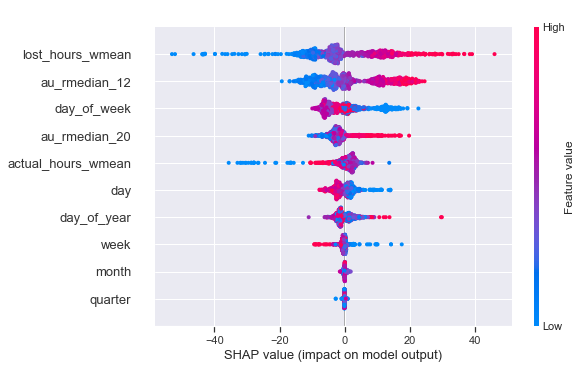

In [172]:
# summarize the effects of all the features
# note inverse day of week
shap.summary_plot(shap_values, X_train)

### End of Notebook